In [1]:
import xarray as xr
import numpy as np
import cftime
import nc_time_axis
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
from cftime import datetime 
import matplotlib.colors as colors
import math
import random
import matplotlib.cm as mcm
jet = mcm.get_cmap('jet')
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from dateutil import tz
import pytz
import time
from time import process_time
%matplotlib inline 

filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Fe_Fep_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Na_Nap_02.nc"
#filename="Nc_Files/Jianfei_WACCMX_files/waccmx_Mg_Mgp_02.nc"

filename2="Nc_Files/Jianfei_WACCMX_files/waccmx_T_Z3_e_02.nc"
filename3="Nc_Files/Jianfei_WACCMX_files/waccmx_winds_02.nc"

M = filename[-9:]
Metal=M[0:2]
#print(Metal)

ds = xr.open_dataset(filename)
ds2 = xr.open_dataset(filename2)
ds3 = xr.open_dataset(filename3)

#ds3

In [2]:
#ds1 variables

dst = ds.transpose("lev", ...)
Mt = dst.variables[str(Metal)]
Mpt = dst.variables[str(Metal)+'p']

In [3]:
#ds2 variables

ds2t = ds2.transpose("lev", ...)
temp = ds2t.variables['T']
elect = ds2t.variables['e']

geopH = ds2t.variables['Z3'] / 1000 #m-> km
Zavg = geopH.mean(('time','lat', 'lon'))

In [4]:
#ds3 variables
ds3t = ds3.transpose("lev", ...)

lon = ds3t.variables['lon'] #(144)
lat = ds3t.variables['lat'] #(96)
lev = ds3t.variables['lev'] #(126)
ilev = dst.variables['ilev'] #(127)

p0 = ds3t.variables['P0']
ps = ds3t.variables['PS'] #(672, 96, 144)
hyai = ds3t.variables['hyai'] #(127)
hybi = ds3t.variables['hybi'] #(127)


U = ds3t.variables['U'] #(126, 672, 96, 144) #U component is positive for a west to east flow (eastward wind) 
V = ds3t.variables['V'] #(126, 672, 96, 144) #V component is positive for south to north flow (northward wind)
omega = ds3t.variables['OMEGA']


In [5]:
timee = ds3t.variables['time'] #(672)
times = xr.cftime_range(start="0001-02-01", periods=672, freq="1H", calendar="noleap")
times2 = ds3t["time"].dt.strftime("%Y%m%d %H:%M")
times3 = ds3t["time"].dt.strftime("%Y%m%d")


In [6]:
#-----------------------------------------------------------------------------------------------------
# Slice arrays (lev, altitude) between chosen range
lev_sl_idx_min = 42
lev_sl_idx_max = 66
lev_sl = lev[lev_sl_idx_min:lev_sl_idx_max+1]

lev_sl_ind_min = lev[lev_sl_idx_min] 
lev_sl_ind_max = lev[lev_sl_idx_max] 
lev_sl_str = str("%.1e" % lev_sl_ind_min) + ' hPa : ' + str("%.1e" % lev_sl_ind_max) + ' hPa'
print('Plot lev = ' + lev_sl_str)


Zavg_sl = Zavg[lev_sl_idx_min:lev_sl_idx_max+1]

Zavg_sl_min = Zavg[lev_sl_idx_min] 
Zavg_sl_max = Zavg[lev_sl_idx_max]
Zavg_sl_str = str("%.0f" % Zavg_sl_min) + ' km : ' + str("%.0f" % Zavg_sl_max) + ' km'
print('Approx Z = ' + Zavg_sl_str)


Plot lev = 1.5e-05 hPa : 6.0e-03 hPa
Approx Z = 128 km : 81 km


In [7]:
# Slice arrays (time) between chosen range

times_idx_min = 0
times_idx_max = 336
times_min = times[times_idx_min]
times_max = times[times_idx_max-1]
times_str_min = str(times_min)
times_str_max = str(times_max)
print('Array time = ' + times_str_min + ' : ' + times_str_max)

Array time = 0001-02-01 00:00:00 : 0001-02-14 23:00:00


In [8]:
#Just slice by time dim and leave full alt dim
geopH_sl_time = geopH[:,times_idx_min:times_idx_max,:,:]

#slice by one extra either side in lev dim so can calculate dU at array edges
U_wind_sl2 = U[lev_sl_idx_min-1:lev_sl_idx_max+2,times_idx_min:times_idx_max,:,:] #(126, 336, 96, 144)
V_wind_sl2 = U[lev_sl_idx_min-1:lev_sl_idx_max+2,times_idx_min:times_idx_max,:,:] #(126, 336, 96, 144)

geopH_sl = geopH[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]

#-----------------------------------------------------------------------------------------------------
# Slice by chosen alt range and time range (first 2 weeks of data)

U_wind = U[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:] #(25, 336, 96, 144)
V_wind = U[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:] #(25, 336, 96, 144)
#-----------------------------------------------------------------------------------------------------
ps_sl = ps[times_idx_min:times_idx_max,:,:] #(336, 96, 144)
hyai_sl = hyai[lev_sl_idx_min:lev_sl_idx_max+2] #(26)
hybi_sl = hybi[lev_sl_idx_min:lev_sl_idx_max+2] #(26)
#-----------------------------------------------------------------------------------------------------

electr = elect[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]
tempe = temp[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]
Mp_t = Mpt[lev_sl_idx_min:lev_sl_idx_max+1,times_idx_min:times_idx_max,:,:]

In [9]:
# VMR to number density calculation
edens = ( electr * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)
Mptdens = ( Mp_t * 1e-6 * 100 * lev_sl ) / (1.380503e-23 * tempe)

In [10]:
timear = np.arange(0,336)
levar = np.arange(0,25)
ilevar = np.arange(0,26)
levarsl = np.arange(0,24)
latar = np.arange(0,96)
lonar = np.arange(0,144)

In [11]:
# Create array with time info for each day 
day = np.arange(0,24)
os =  day * 15 / 2.5 # Create an array with offset needed for each UT time step (24h period) - Offset by 15 degrees lon, lon axis is in 2.5 degree intervals

offset = np.empty(24, dtype=int) #Create offset array so it has same dims as day variable

for d in day:
    offset[d] =  ( int(os[d]) ) #convert floats to ints to get integer number of indices to offset by
print(offset)

# Stack multiple offset arrays to give offsets for consecutive days in the 2 week dataset 
offset2 = np.stack((offset, offset, offset, offset, offset, offset, offset), axis=0)
offset2 = np.reshape(offset2, (24*7))
offset3 = np.stack((offset2, offset2), axis=0)
offset3 = np.reshape(offset3, (168*2))

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138]


In [12]:
#Create _sh array so it has same dims etc as dens variable
U_wind_sh = np.ndarray(U_wind.shape, dtype = float) 
V_wind_sh = np.ndarray(V_wind.shape, dtype = float) 

U_wind_sl2_sh = np.ndarray(U_wind_sl2.shape, dtype = float) 
V_wind_sl2_sh = np.ndarray(V_wind_sl2.shape, dtype = float) 


#Iterate over timear, offsetting at each time by 15 degrees lon
for it in timear:
    U_wind_sh[:,it,:,:] = np.roll(U_wind[:,it,:,:], offset3[it] , axis=2)
    V_wind_sh[:,it,:,:] = np.roll(V_wind[:,it,:,:], offset3[it] , axis=2)
    
    U_wind_sl2_sh[:,it,:,:] = np.roll(U_wind_sl2[:,it,:,:], offset3[it] , axis=2)
    V_wind_sl2_sh[:,it,:,:] = np.roll(V_wind_sl2[:,it,:,:], offset3[it] , axis=2)

In [13]:
Mptdens_sh = np.ndarray(Mptdens.shape, dtype = float) 
edens_sh = np.ndarray(edens.shape, dtype = float) 

#Iterate over timear, offsetting density at each time by 15 degrees lon
timear = np.arange(0,336)
for it in timear:
    edens_sh[:,it,:,:] = np.roll(edens[:,it,:,:], offset3[it] , axis=2)
    Mptdens_sh[:,it,:,:] = np.roll(Mptdens[:,it,:,:], offset3[it] , axis=2)
    

In [14]:
#Define one lat for below calculations

lat_plot_idx = 21   #-50.2
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('Plot lat = ' + lat_plot_str)


Plot lat = -50.2


In [15]:
#Calculate dz with geopotential height instead

alt_up = np.ndarray((25,336,96,144), dtype = float) 
alt_low = np.ndarray((25,336,96,144), dtype = float) 
dz = np.ndarray((25,336,96,144), dtype = float) 


#Set alti for first lev index 
alt_up[0,:,:,:] = ( geopH_sl_time[lev_sl_idx_min-1,:,:,:] + geopH_sl[0,:,:,:] ) / 2.
alt_low[0,:,:,:] = ( geopH_sl[0,:,:,:] + geopH_sl[1,:,:,:] ) / 2.
dz[0,:,:,:] = alt_up[0,:,:,:] - alt_low[0,:,:,:]

#Set alti for last lev index
alt_up[24,:,:,:] = ( geopH_sl[23,:,:,:] + geopH_sl[24,:,:,:] ) / 2.
alt_low[24,:,:,:] = ( geopH_sl[24,:,:,:] + geopH_sl_time[lev_sl_idx_max+1,:,:,:] ) / 2.
dz[24,:,:,:] = alt_up[24,:,:,:] - alt_low[24,:,:,:]

levarch = levar[1:-1]

start_time = time.process_time()

for ilevch in levarch:
    alt_up[ilevch,:,:,:] = ( geopH_sl[ilevch-1,:,:,:] + geopH_sl[ilevch,:,:,:] ) / 2.
    alt_low[ilevch,:,:,:] = ( geopH_sl[ilevch,:,:,:] + geopH_sl[ilevch+1,:,:,:] ) / 2.
    dz[ilevch,:,:,:] = alt_up[ilevch,:,:,:] - alt_low[ilevch,:,:,:] 

end_time = time.process_time()
print(end_time - start_time) #3.0914399220000632

dz = dz * 1000. #km --> m


#Convert dz into local time grid--------------------------------------------

#Create _sh array so it has same dims etc as dz variable
dz_sh = np.ndarray(dz.shape, dtype = float) #(25, 336, 96, 144)

#Iterate over timear, offsetting at each time by 15 degrees lon
for it in timear:
    dz_sh[:,it,:,:] = np.roll(dz[:,it,:,:], offset3[it] , axis=2)
#---------------------------------------------------------------------------

3.400129910999965


In [23]:
#manual calc using dz calculated from geopH
#U wind is in local time

U_up = np.ndarray((25, 336, 96, 144), dtype = float)
U_low = np.ndarray((25, 336, 96, 144), dtype = float)
dU = np.ndarray((25, 336, 96, 144), dtype = float)  
dUdz = np.ndarray((25, 336, 96, 144), dtype = float)


V_up = np.ndarray((25, 336, 96, 144), dtype = float)
V_low = np.ndarray((25, 336, 96, 144), dtype = float)
dV = np.ndarray((25, 336, 96, 144), dtype = float)  
dVdz = np.ndarray((25, 336, 96, 144), dtype = float)

dU2V2 = np.ndarray((25, 336, 96, 144), dtype = float)
dU2V2dz = np.ndarray((25, 336, 96, 144), dtype = float)


levarr = np.arange(1,26) #1-->25

start_time = time.process_time()
for ilev in levarr:
    U_up[ilev-1,:,:,:] = U_wind_sl2_sh[ilev-1,:,:,:] - U_wind_sl2_sh[ilev,:,:,:] #ms-1
    U_low[ilev-1,:,:,:] = U_wind_sl2_sh[ilev,:,:,:] - U_wind_sl2_sh[ilev+1,:,:,:] #ms-1
    dU[ilev-1,:,:,:] = U_up[ilev-1,:,:,:] - U_low[ilev-1,:,:,:] #ms-1

for ilev in levarr:
    V_up[ilev-1,:,:,:] = V_wind_sl2_sh[ilev-1,:,:,:] - V_wind_sl2_sh[ilev,:,:,:] #ms-1
    V_low[ilev-1,:,:,:] = V_wind_sl2_sh[ilev,:,:,:] - V_wind_sl2_sh[ilev+1,:,:,:] #ms-1
    dV[ilev-1,:,:,:] = V_up[ilev-1,:,:,:] - V_low[ilev-1,:,:,:] #ms-1
end_time = time.process_time()
print(end_time - start_time) #3.733

dUdz = dU / dz_sh #s-1
dVdz = dV / dz_sh #s-1

start_time = time.process_time()
for ilev in levar:
    for it in timear:
        for ilat in latar:
            for ilon in lonar:
                dU2V2[ilev,it,ilat,ilon] = math.sqrt( ( dU[ilev,it,ilat,ilon]**2 ) + ( dV[ilev,it,ilat,ilon]**2 ) )
end_time = time.process_time()
print(end_time - start_time) #122.89

dU2V2dz = dU2V2 / dz


3.7332539319999682
122.890636755


In [24]:
#------------------------ Plot2 setup: SpEs_plot-----------------------------

lat_plot_idx = 21   #15 #~94km      #23=82km low lim?
lat_plot = lat[lat_plot_idx]
lat_plot_str = str("%.1f" % lat_plot) 
print('Plot lat = ' + lat_plot_str)

lev_sl_plot_min = lev_sl[0]
lev_sl_plot_max = lev_sl[-1]
lev_sl_plot_min_str = str("%.1e" % lev_sl_plot_min) + ' hPa'
lev_sl_plot_max_str = str("%.1e" % lev_sl_plot_max) + ' hPa'
print('Lev = ' + lev_sl_plot_max_str + ' : ' + lev_sl_plot_min_str)

Zavg_sl_plot_min = Zavg_sl[0]
Zavg_sl_plot_max = Zavg_sl[-1]
Zavg_sl_plot_min_str = str("%.0f" % Zavg_sl_plot_min) + ' km'
Zavg_sl_plot_max_str = str("%.0f" % Zavg_sl_plot_max) + ' km'
print('Approx Z = ' + Zavg_sl_plot_max_str + ' : ' + Zavg_sl_plot_min_str)


timeconv = lon / 15
timeconv_plot = timeconv.to_numpy() 

timeconv_plot_ticks = np.arange(0,25, dtype=float)

Plot lat = -50.2
Lev = 6.0e-03 hPa : 1.5e-05 hPa
Approx Z = 81 km : 128 km


In [18]:
#Adding in additional criteria (U +ve above and -ve below) : dUdz variable
# dUdz calculated using dz calculated from geopH

# Took too long (~6 mins) for all lats, so calculate for lat_plot_idx only

dUdz_2 = np.ndarray((25, 336, 144), dtype = float)
dUdz_2_NaN = np.empty((25, 336, 144), dtype = float)
dUdz_2_NaN[:,:,:] = np.NaN

start_time = time.process_time()

for it in timear:
    for ilon in lonar:
        for ilev in levar:
            dUdz_2[ilev,it,ilon] = np.where( (U_up[ilev,it,lat_plot_idx,ilon]<0.)&(U_low[ilev,it,lat_plot_idx,ilon]>0.), dUdz[ilev,it,lat_plot_idx,ilon] , dUdz_2_NaN[ilev,it,ilon] )
            
end_time = time.process_time()
print(end_time - start_time) #357.5188 for all lats, 4.600 for one lat




3.9952454460000126


In [25]:
#Adding in additional criteria (V +ve above and -ve below) : dVdz variable
# dVdz calculated using dz calculated from geopH

# Calculate for lat_plot_idx only

dVdz_2 = np.ndarray((25, 336, 144), dtype = float)
dVdz_2_NaN = np.empty((25, 336, 144), dtype = float)
dVdz_2_NaN[:,:,:] = np.NaN

start_time = time.process_time()

for it in timear:
    for ilon in lonar:
        for ilev in levar:
            dVdz_2[ilev,it,ilon] = np.where( (V_up[ilev,it,lat_plot_idx,ilon]<0.)&(V_low[ilev,it,lat_plot_idx,ilon]>0.), dVdz[ilev,it,lat_plot_idx,ilon] , dVdz_2_NaN[ilev,it,ilon] )
            
end_time = time.process_time()
print(end_time - start_time) #3.99



3.9980540419999215


In [26]:
#Calculate Winds_Occ_Fr where dUdz meets conditions over 2 week time period

#Create array, where dUdz_2 is a number, set to True, otherwise set to False
dUdz_2_fr = np.empty(dUdz_2.shape) #(25,336,144)
dUdz_2_fr_bool = np.isfinite(dUdz_2) 
dUdz_2_fr = dUdz_2_fr_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
dUdz_2_fr_time = np.empty((25,144))
dUdz_2_fr_time = np.sum(dUdz_2_fr, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(dUdz_2, axis=1) #336
Winds_Occ_Fr = ( dUdz_2_fr_time / timedim_len ) *100.


In [31]:
#Calculate Winds_Occ_Fr where dVdz meets conditions over 2 week time period

#Create array, where dVdz_2 is a number, set to True, otherwise set to False
dVdz_2_fr = np.empty(dVdz_2.shape) #(25,336,144)
dVdz_2_fr_bool = np.isfinite(dVdz_2) 
dVdz_2_fr = dVdz_2_fr_bool *1. #Convert True/False to 1/0s

#Sum over Time dimension to give SpEs_sh_freq_time variable (total occurences in 2 week time period)
dVdz_2_fr_time = np.empty((25,144))
dVdz_2_fr_time = np.sum(dVdz_2_fr, axis=1) 

#Divide by number of timesteps to give occurence freq (%)
timedim_len = np.size(dVdz_2, axis=1) #336
Winds_Occ_Fr_V = ( dVdz_2_fr_time / timedim_len ) *100.

/tmp/ipykernel_1665431/600150152.py:70: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1665431/600150152.py:70: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1665431/600150152.py:70: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To sile

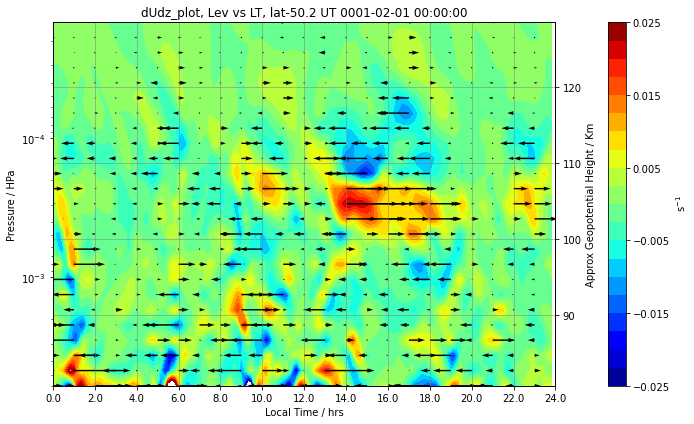

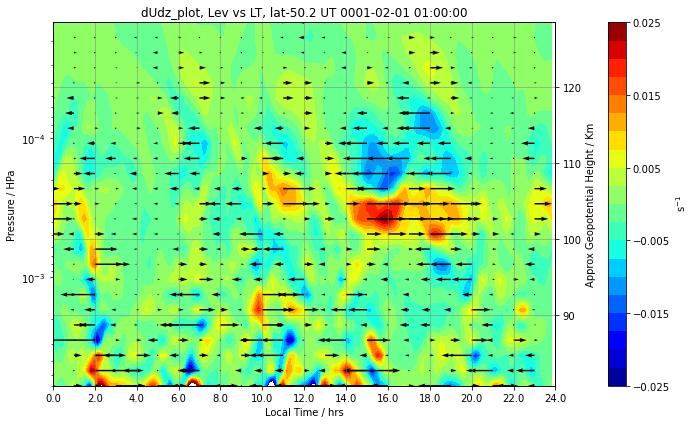

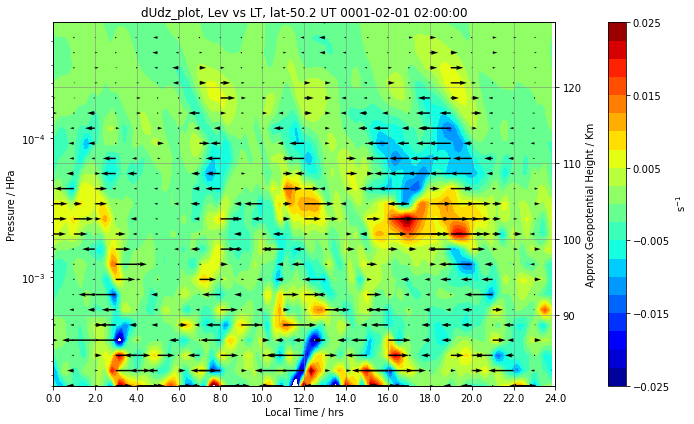

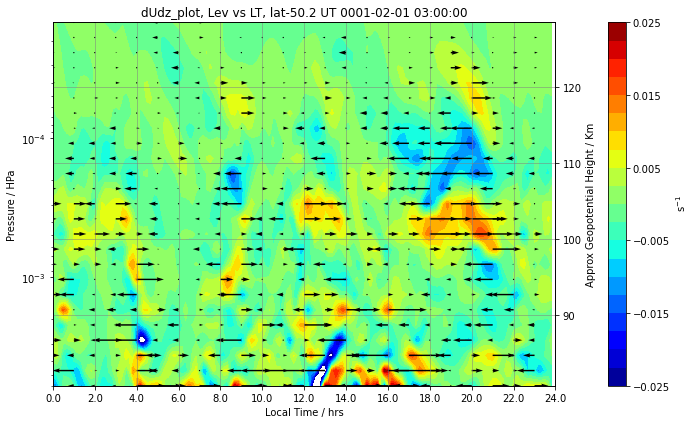

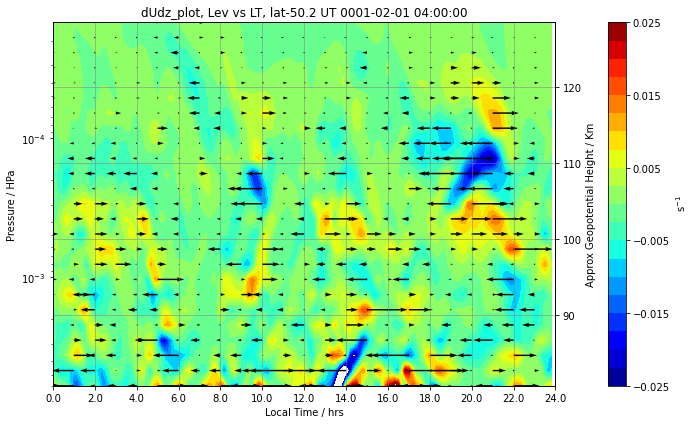

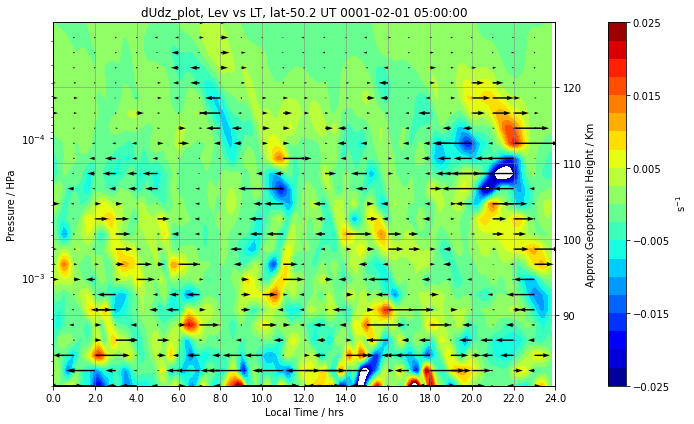

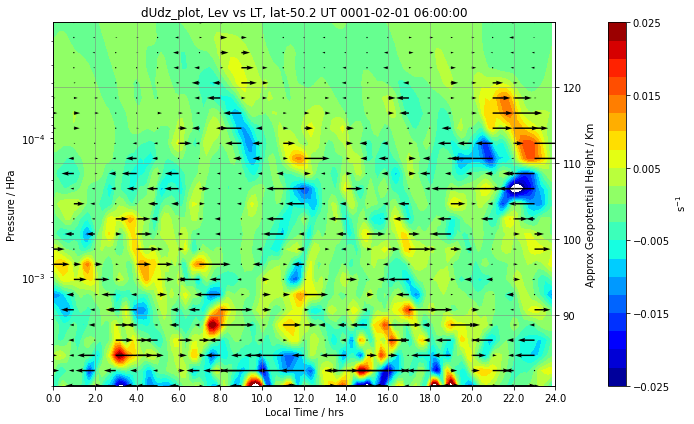

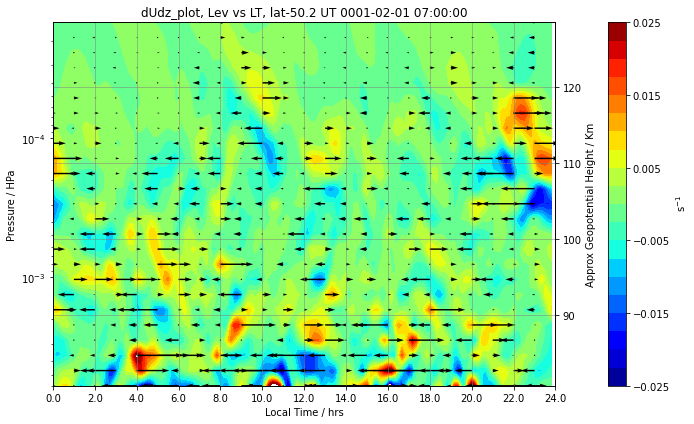

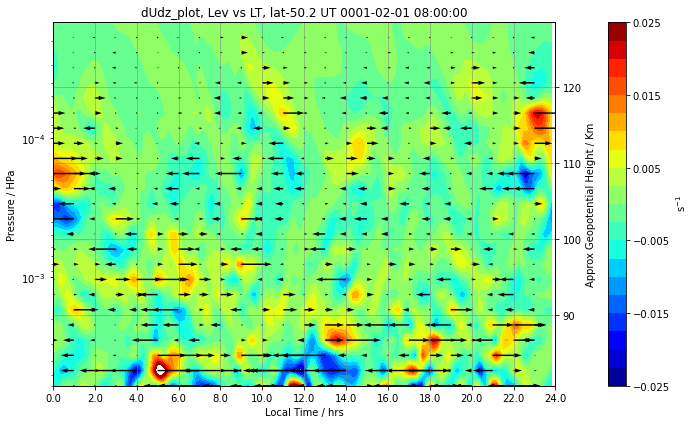

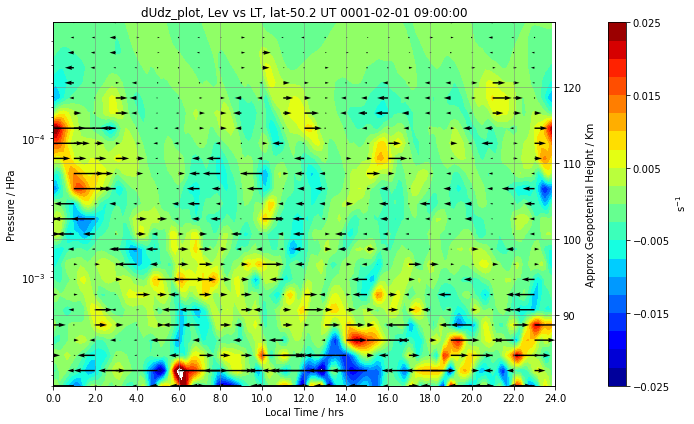

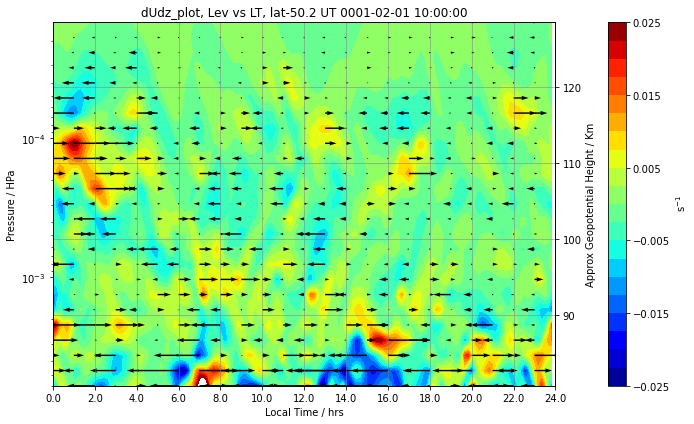

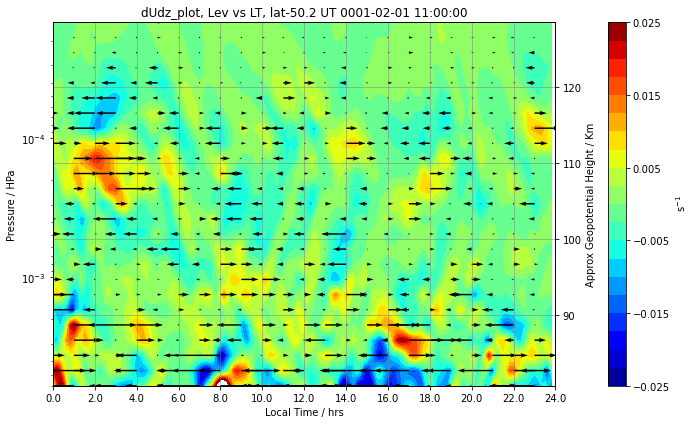

In [44]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  dUdz_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dUdz_plot = dUdz[:,time_plot_idx,lat_plot_idx,:] # manual calculation
    dUdz_2_plot = dUdz_2[:,time_plot_idx,:] # Criteria of U -ve above and +ve below
   
    #------------------------ SpEs_pd_plot -----------------------------

    #ticks = np.linspace(-0.05, 0.05, 21)
    ticks = np.linspace(-0.025, 0.025, 21)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl, dUdz_plot, #lev_sl[0:-1]
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl, dUdz_plot[:,::6], 0.,  #lev_sl[0:-1] 
        scale=0.03, scale_units='inches', units='inches', width=0.02) #scale=0.03
    
    #Not working
    #P = ax.quiver(timeconv_plot[::6], lev_sl[0:-1], 0., dVdz_plot[0:-1,::6],  #lev_sl[0:-1] 
    #    scale=0.03, scale_units='inches', units='inches', width=0.02) #scale=0.03
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('dUdz_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' s$^{-1}$')

    figname='dUdz_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_311288/3774997922.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_311288/3774997922.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_311288/3774997922.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To sile

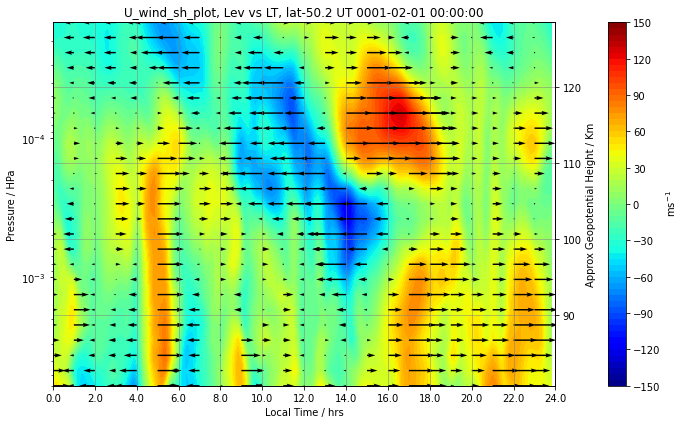

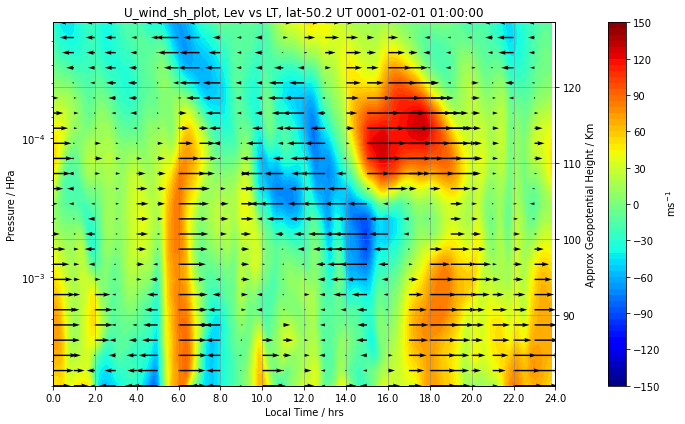

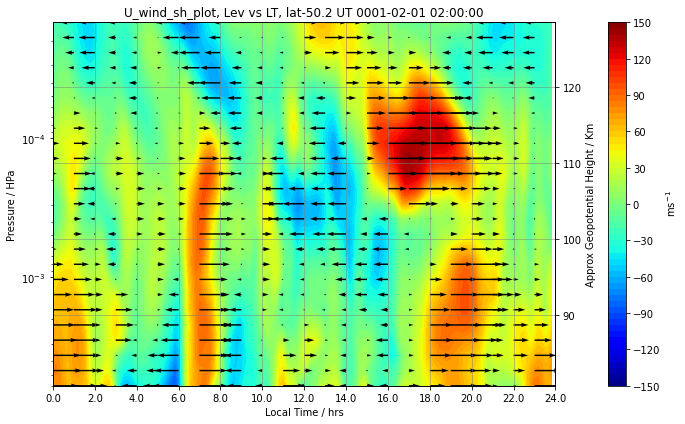

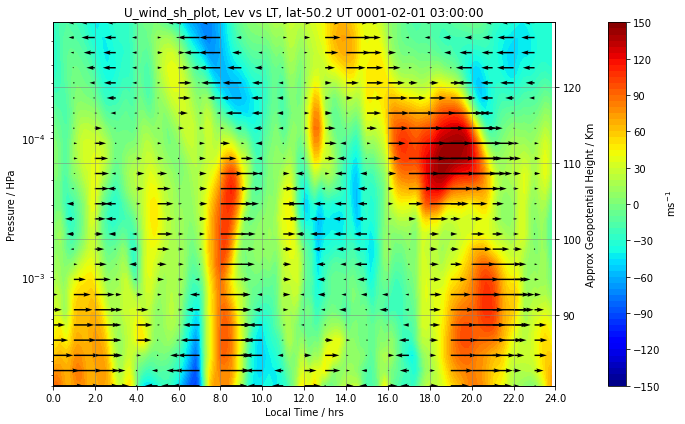

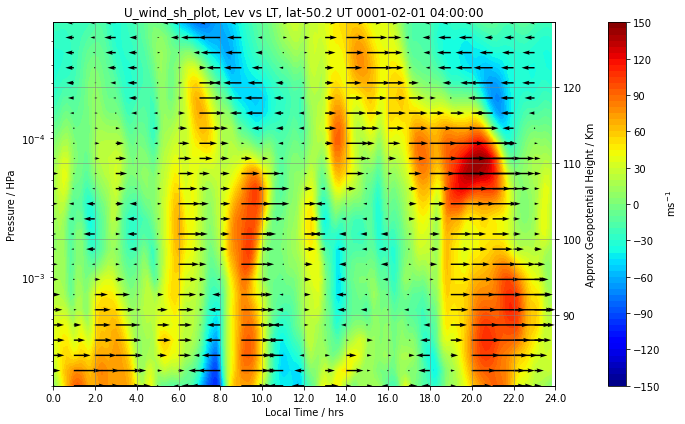

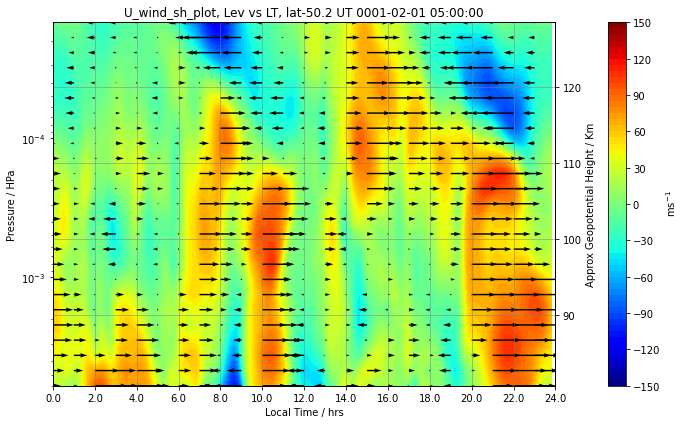

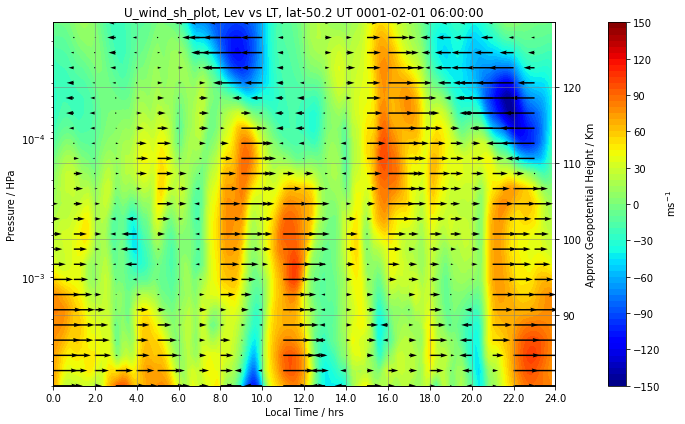

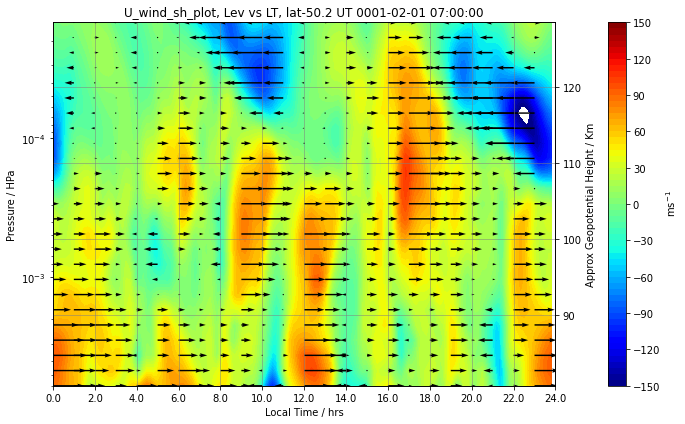

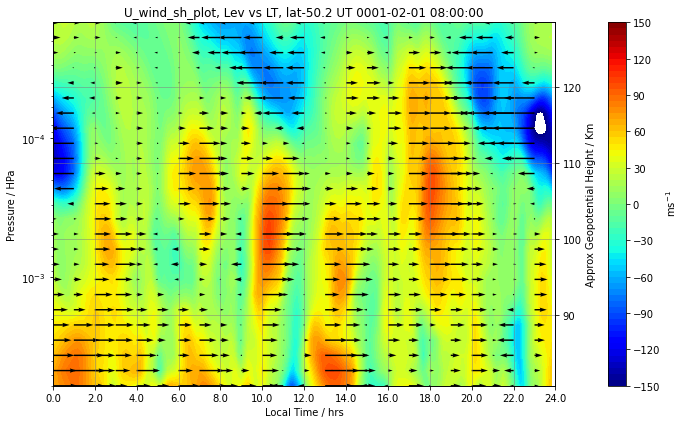

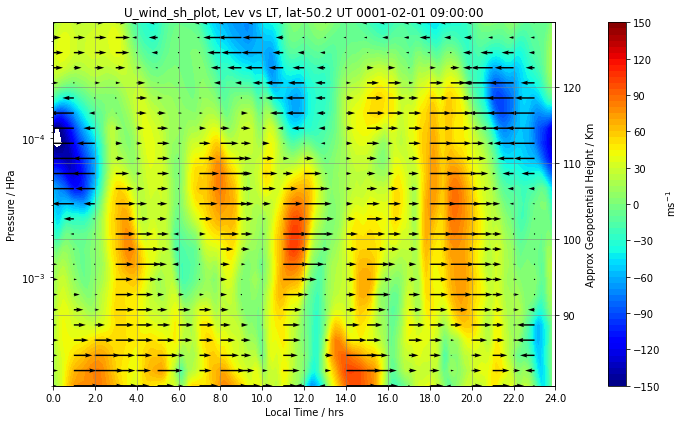

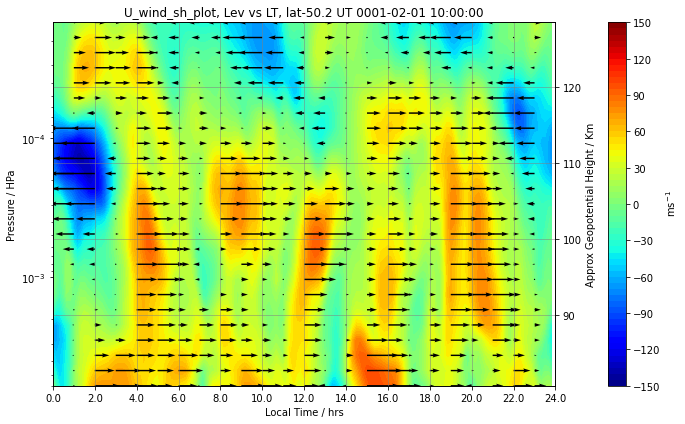

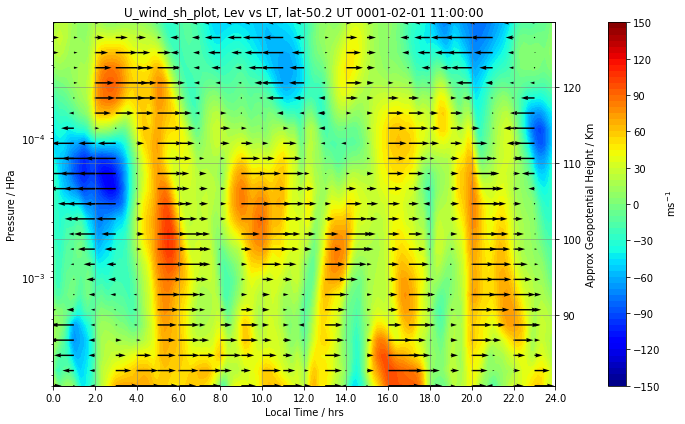

In [167]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  U_wind_sh_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    #U_wind_sh_plot = U_wind_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    U_wind_sh_plot = U_wind_sh[:,time_plot_idx,lat_plot_idx,:]
    
    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.linspace(-150, 150, 61)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl, U_wind_sh_plot,  #lev_sl[0:-1]
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl, U_wind_sh_plot[:,::6], 0.,    #lev_sl[0:-1]
                     scale=200, scale_units='inches', units='inches', width=0.02)
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('U_wind_sh_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' ms$^{-1}$')

    figname='U_wind_sh_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_1665431/863643041.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1665431/863643041.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1665431/863643041.py:63: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To sile

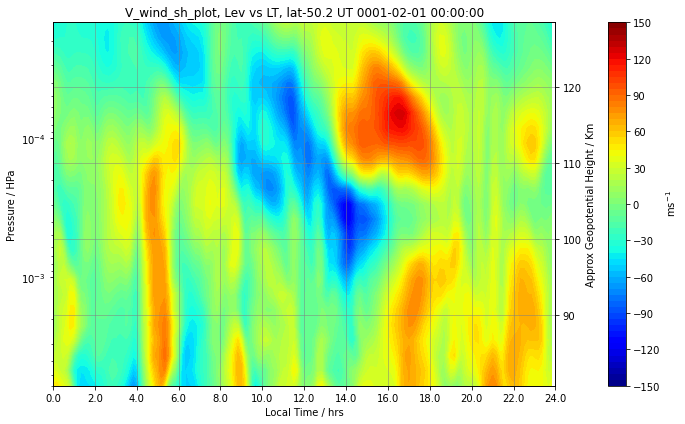

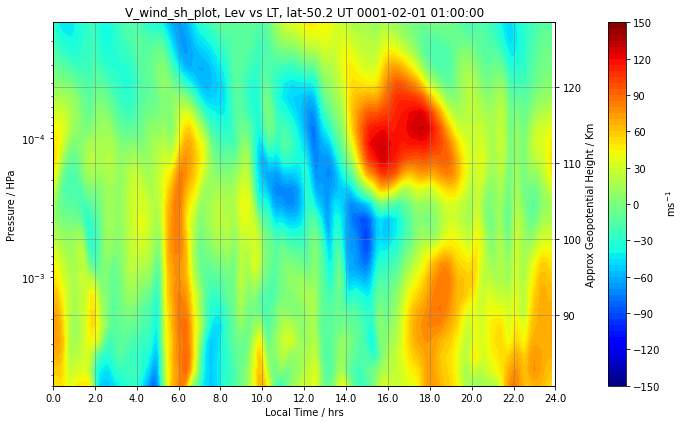

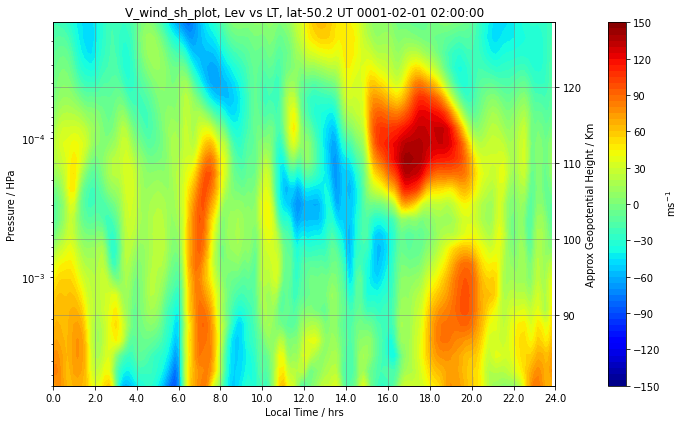

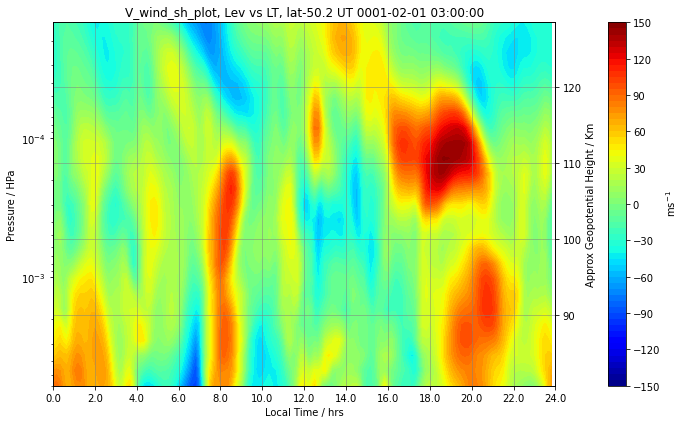

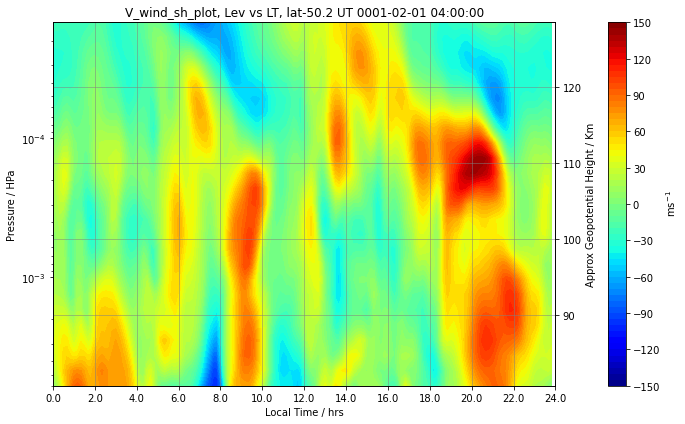

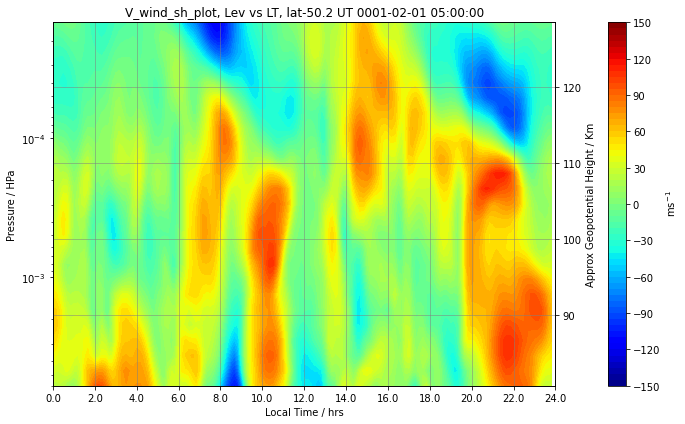

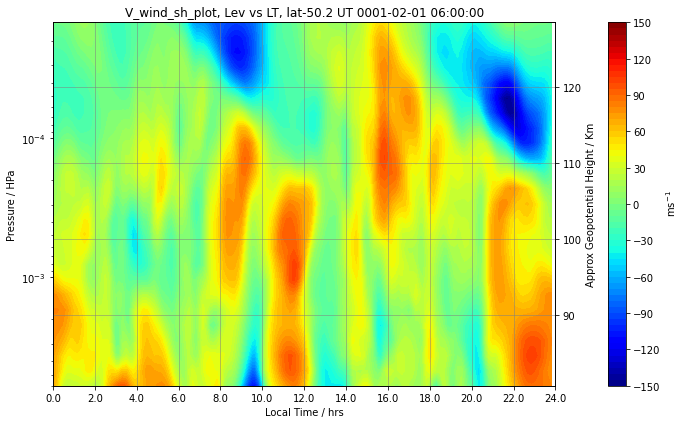

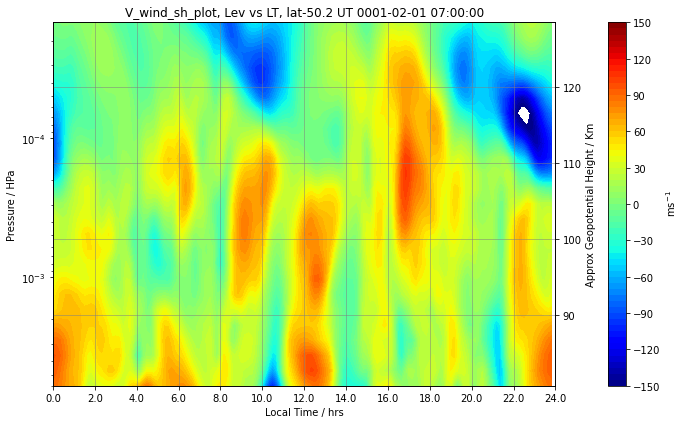

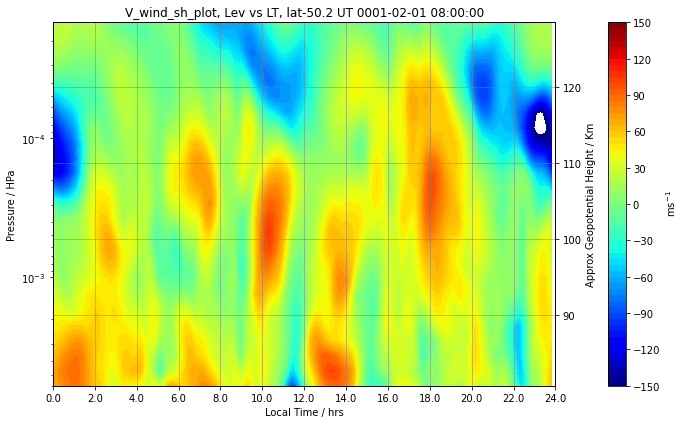

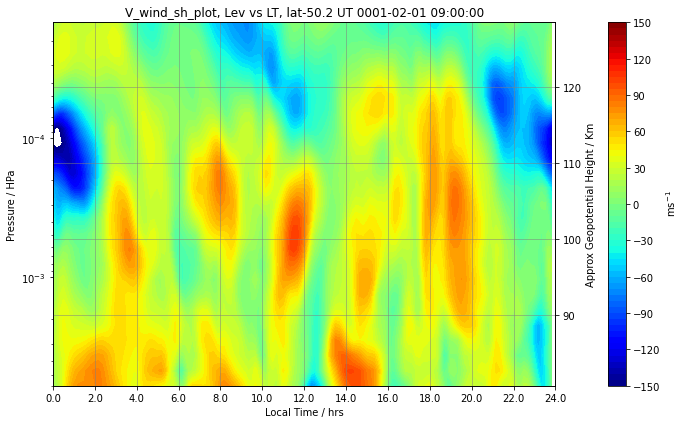

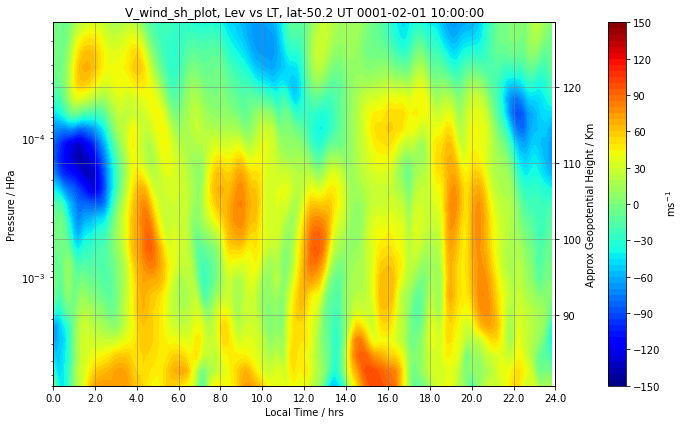

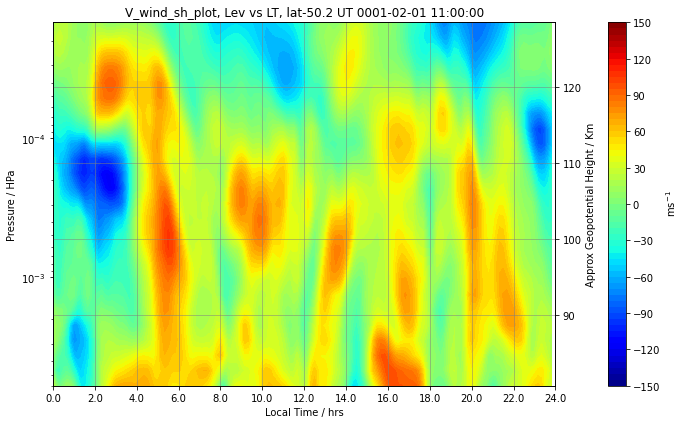

In [49]:

#This code is coming out the same as the U wind... either it's not plotting correctly or plotting on these axes isn't scientifically valid...

#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  V_wind_sh_plot arrows  -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    
    V_wind_sh_plot = V_wind_sh[:,time_plot_idx,lat_plot_idx,:]
    
    #------------------------ SpEs_pd_plot -----------------------------

    ticks = np.linspace(-150, 150, 61)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl, V_wind_sh_plot,  #lev_sl[0:-1]
                     levels=ticks,
                     #locator=ticker.LogLocator(),
                     #extend='min',
                     cmap=jet)

    #P = ax.quiver(timeconv_plot[::6], lev_sl, V_wind_sh_plot[:,::6], 0.,    #lev_sl[0:-1]
    #                 scale=200, scale_units='inches', units='inches', width=0.02)
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('V_wind_sh_plot, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::6])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    cbar.set_label(r' ms$^{-1}$')

    figname='V_wind_sh_plot: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    #plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_311288/2781481480.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_311288/2781481480.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_311288/2781481480.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence 

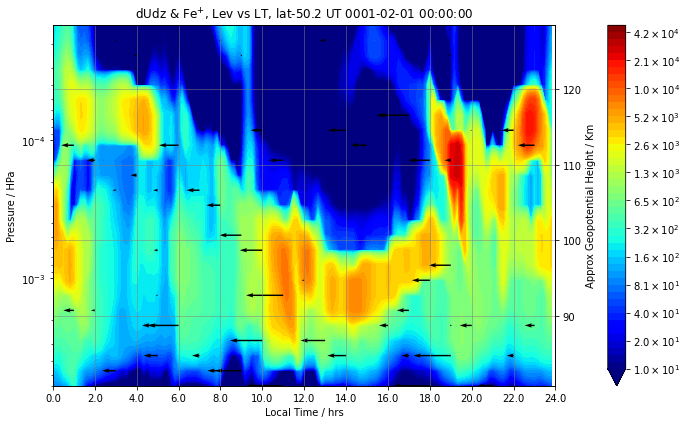

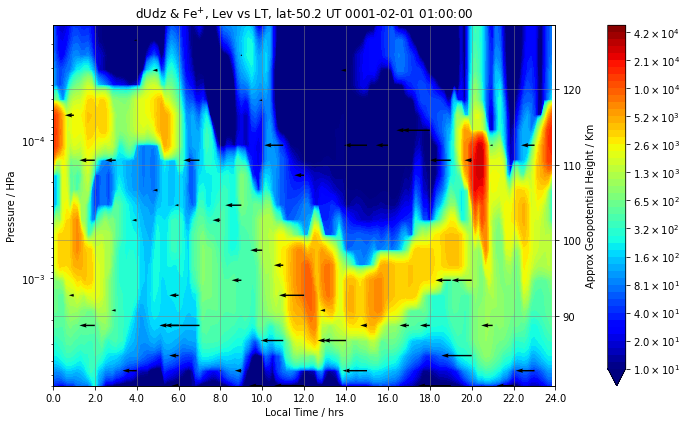

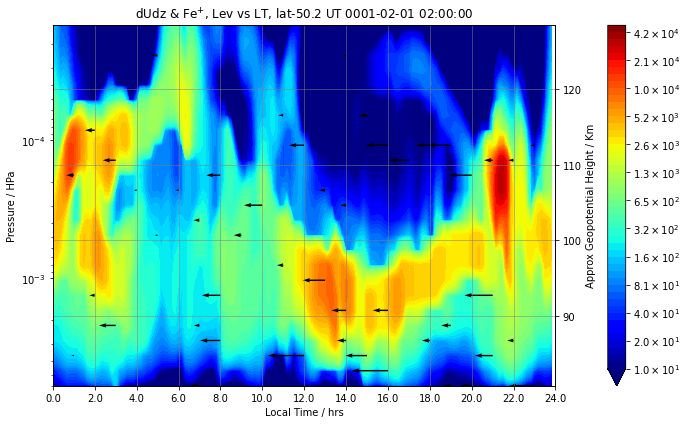

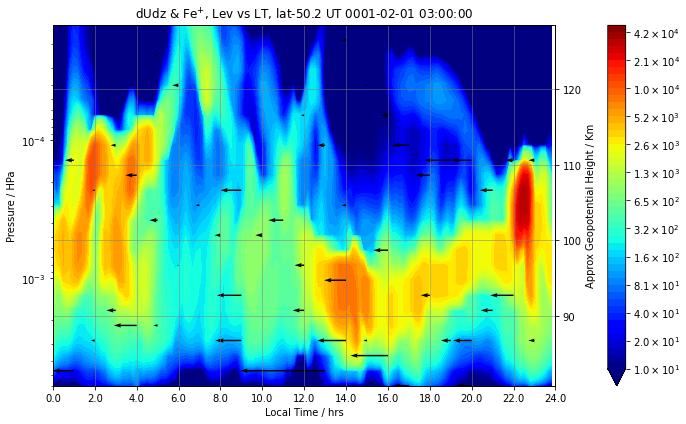

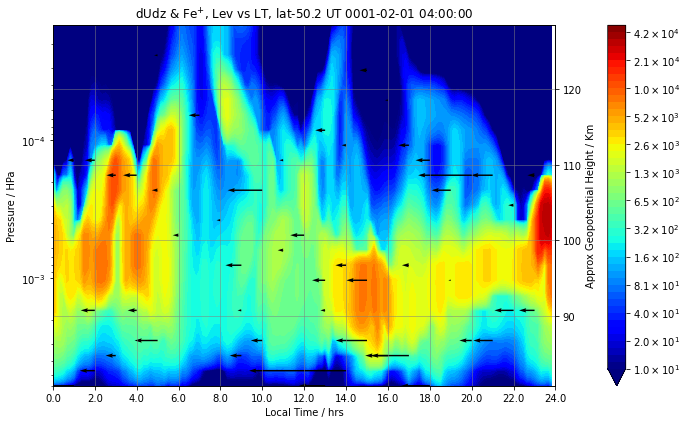

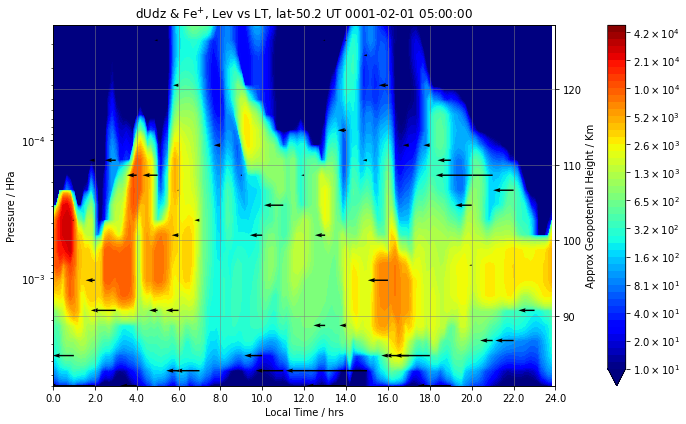

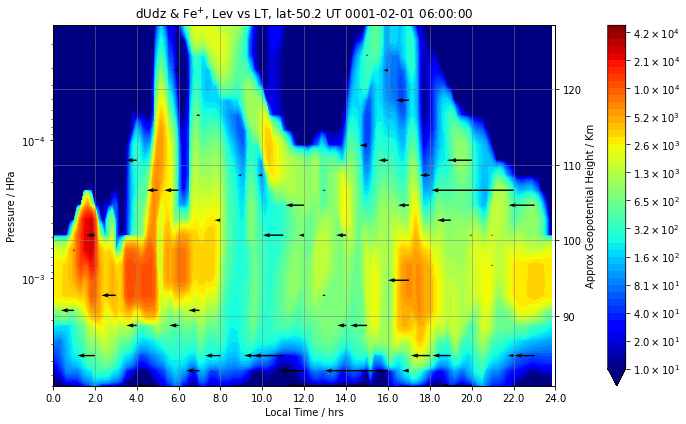

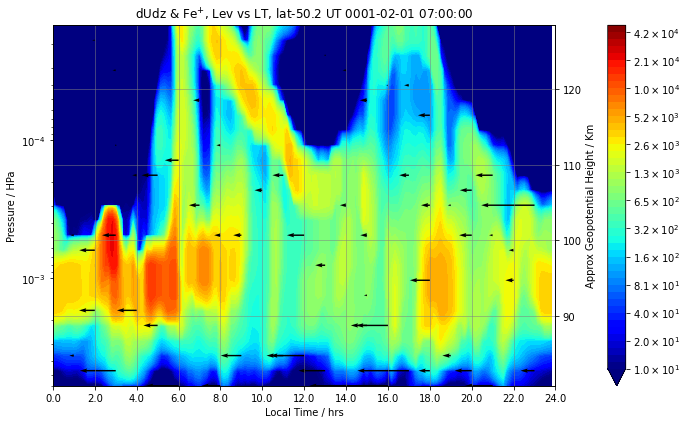

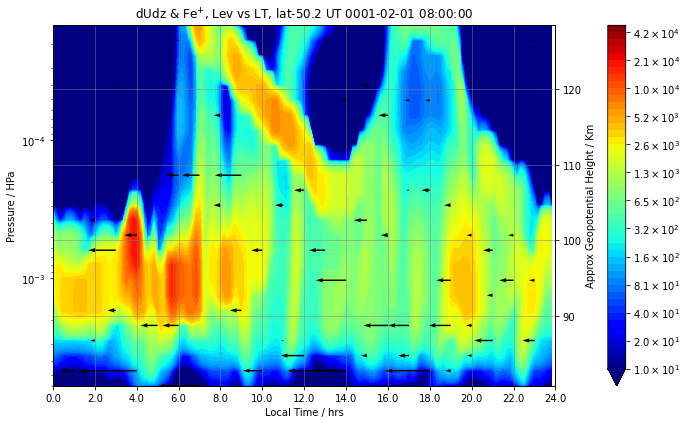

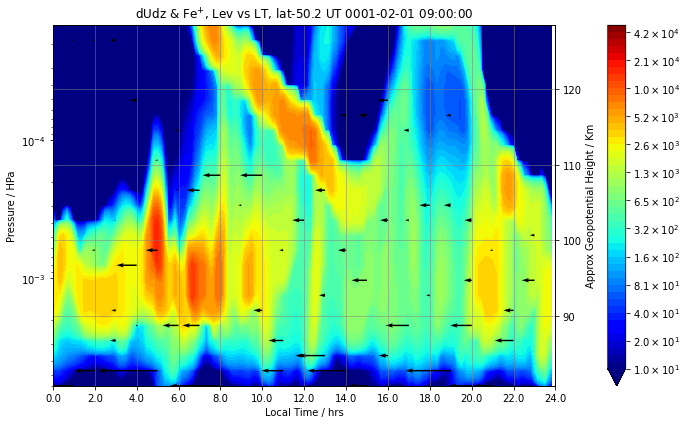

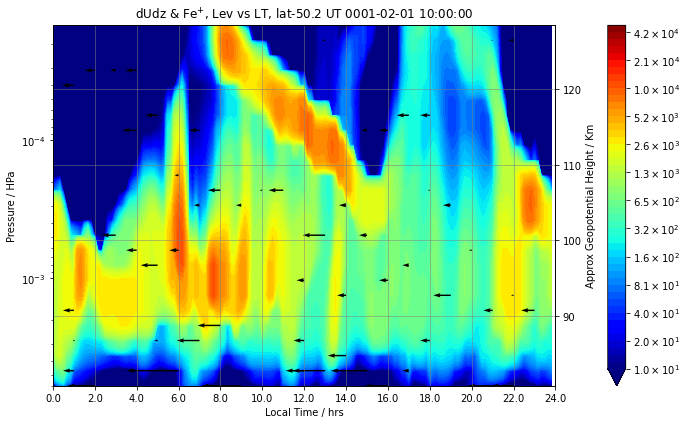

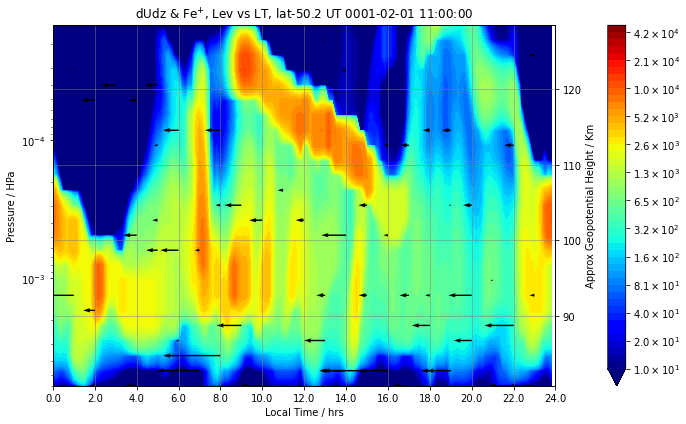

In [164]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  dUdz_plot arrows + Mptdens_sh_plot -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dUdz_2_plot = dUdz_2[:,time_plot_idx,:] # Criteria of U -ve above and +ve below
    
    #edens_sh_plot = edens_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    #Mptdens_sh_plot = Mptdens_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    edens_sh_plot = edens_sh[:,time_plot_idx,lat_plot_idx,:]
    Mptdens_sh_plot = Mptdens_sh[:,time_plot_idx,lat_plot_idx,:]
    #------------------------ SpEs_pd_plot -----------------------------

    #ticks = np.linspace(-50, 50, 21)
    ticks = np.geomspace(1*10**1, 5*10**4)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl, Mptdens_sh_plot, #lev_sl[0:-1]
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl, dUdz_2_plot[:,::6], 0.,  #lev_sl[0:-1]
                     scale=0.03, scale_units='inches', units='inches', width=0.02)   #30
    
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('dUdz & Fe$^{+}$, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    #cbar.set_label(r' s$^{-1}$')

    figname='dUdz_2_plot,Fep: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_1161776/3905427420.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1161776/3905427420.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023,
/tmp/ipykernel_1161776/3905427420.py:68: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silen

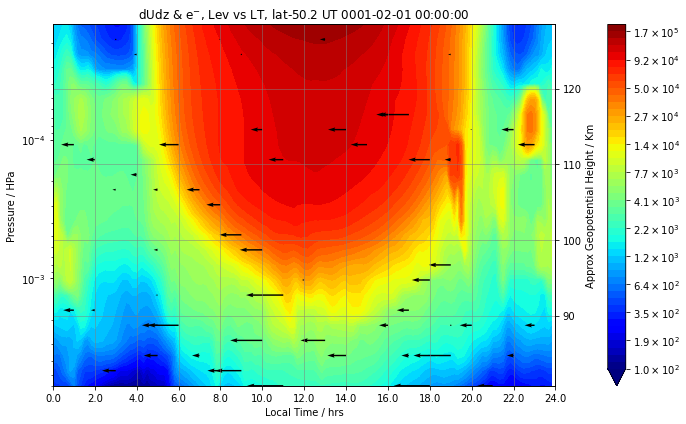

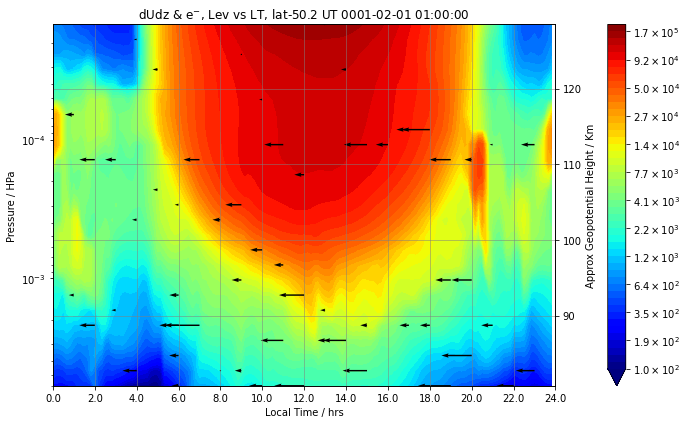

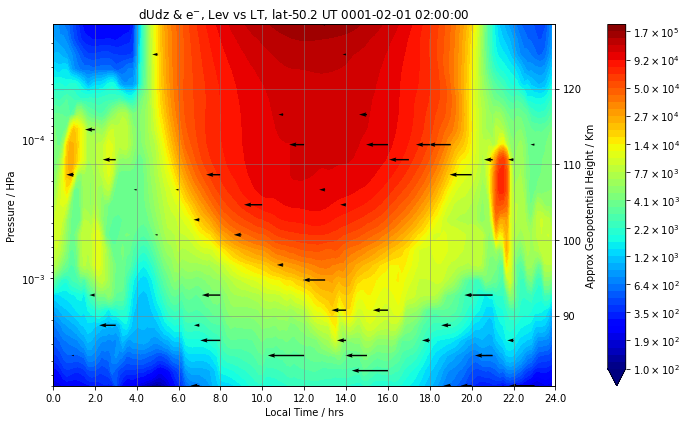

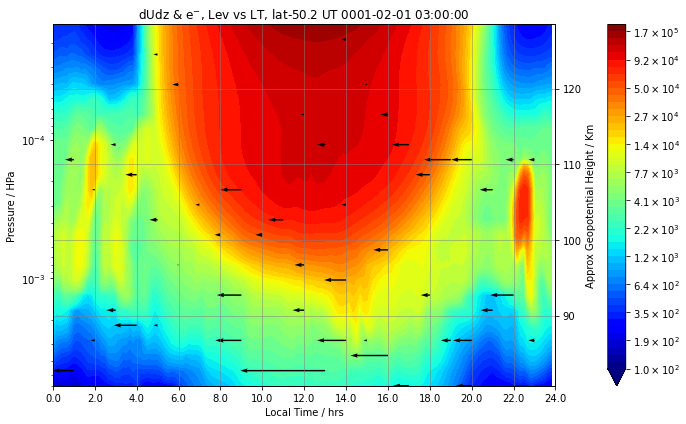

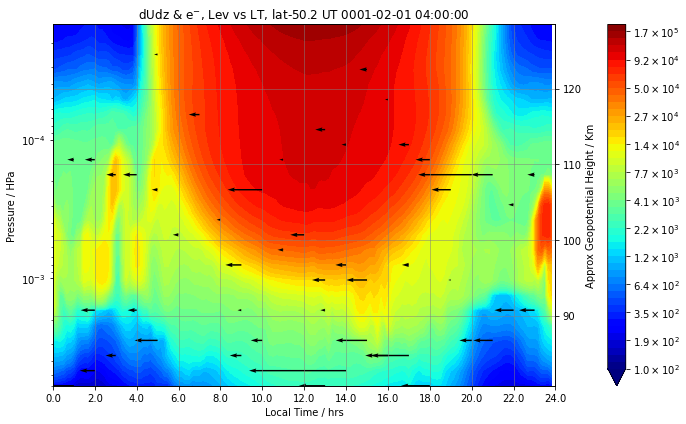

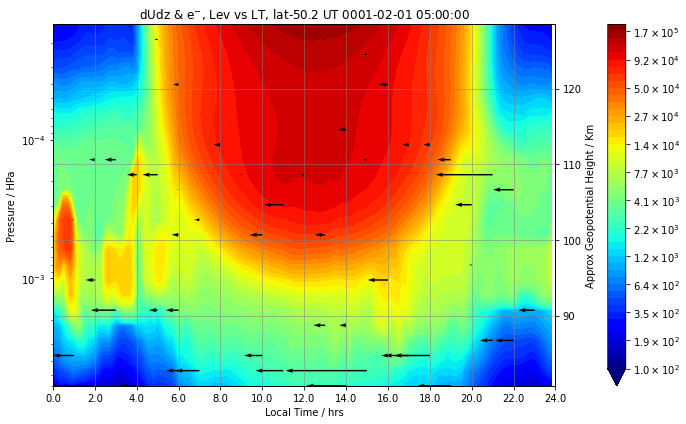

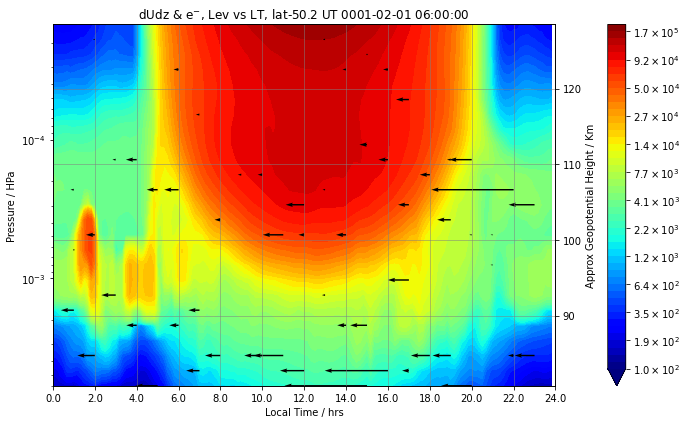

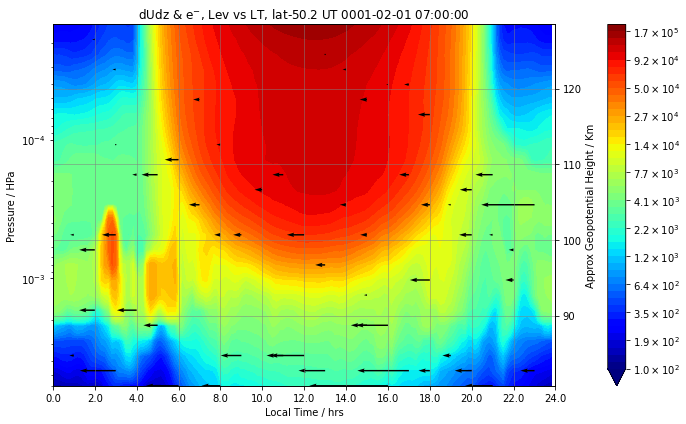

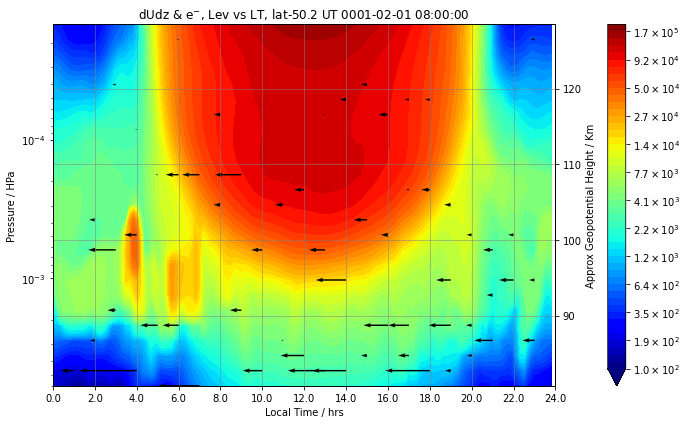

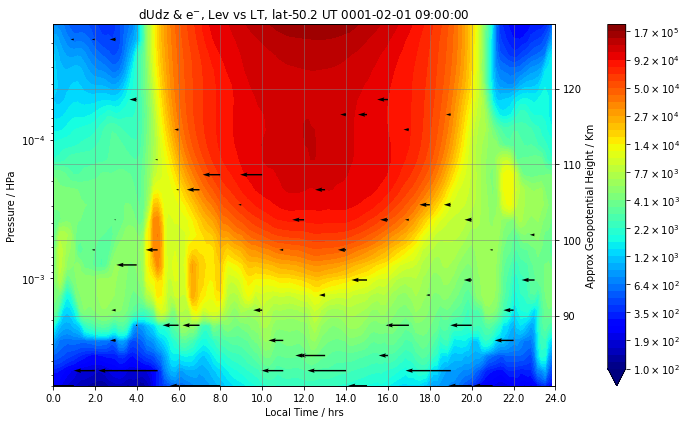

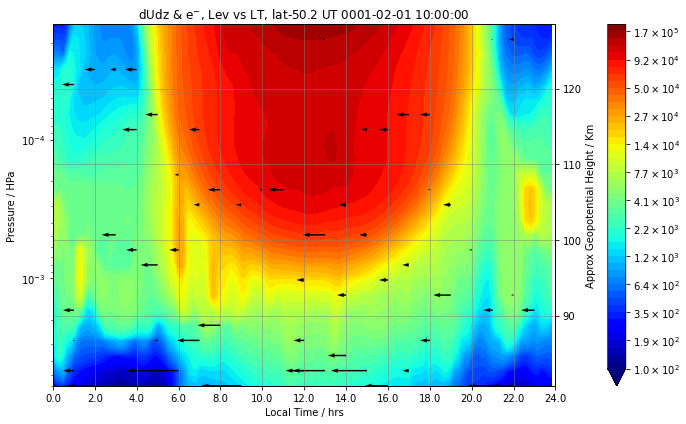

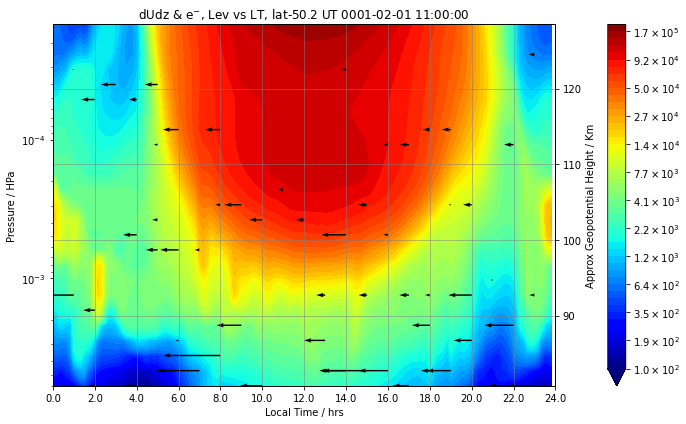

In [30]:
#----------------------------------------------------------------------------------------------------------
#-----------------------------------------  dUdz_plot arrows + edens_sh_plot -----------------------------------------------------
#----------------------------------------------------------------------------------------------------------

time_plot_idx_start = 0  
time_plot_idx_end = 12

time_plot_ar = np.arange(time_plot_idx_start,time_plot_idx_end)

for itime in time_plot_ar:
    time_plot_idx = time_plot_ar[itime]

    
    #--------------- Plot 1 setup: time -------------------------
    time_plot = timee[time_plot_idx]
    times_plot = times[time_plot_idx]
    times_plot_str = str(times_plot)
    #print('Plot time = ' + times_plot1_str)   

    #---------------Set up plot variables----------------------------
    dUdz_2_plot = dUdz_2[:,time_plot_idx,:] # Criteria of U -ve above and +ve below
    
    #edens_sh_plot = edens_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    #Mptdens_sh_plot = Mptdens_sh[0:-1,time_plot_idx,lat_plot_idx,:]
    
    edens_sh_plot = edens_sh[:,time_plot_idx,lat_plot_idx,:]
    Mptdens_sh_plot = Mptdens_sh[:,time_plot_idx,lat_plot_idx,:]
    #------------------------ SpEs_pd_plot -----------------------------

    #ticks = np.linspace(-50, 50, 21)
    ticks = np.geomspace(1*10**2, 2*10**5)

    #fig, ax = plt.subplots(figsize=(8, 5))
    fig, ax = plt.subplots(figsize=(10, 6))
    C = ax.contourf(timeconv_plot, lev_sl, edens_sh_plot, #lev_sl[0:-1]
                     levels=ticks,
                     locator=ticker.LogLocator(),
                     extend='min',
                     cmap=jet)

    P = ax.quiver(timeconv_plot[::6], lev_sl, dUdz_2_plot[:,::6], 0.,   #lev_sl[0:-1] 
                     scale=0.03, scale_units='inches', units='inches', width=0.02)   #30
    
    ax.set_yscale('log')
    ax.set_ylabel('Pressure / HPa')
    ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

    ax2 = ax.twinx()
    ax2.set_ylabel('Approx Geopotential Height / Km')
    ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


    ax.set_xlabel('Local Time / hrs')
    ax.set_xticks(np.linspace(0,24,13)) 
    ax.set_xticklabels(timeconv_plot_ticks[::2]) 

    ax.set_title('dUdz & e$^{-}$, Lev vs LT, lat' + lat_plot_str + ' UT ' + times_plot_str )

    ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
    plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

    #------------------
    def fmt(x, pos):
        a, b = '{:.1e}'.format(x).split('e')
        b = int(b)
        return r'${} \times 10^{{{}}}$'.format(a, b)

    cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4],format=ticker.FuncFormatter(fmt))#fraction=0.023, 
    #-------------------

    #cbar.set_label(r' s$^{-1}$')

    figname='dUdz_2_plot,e-: Lev vs LT, lat' + lat_plot_str + ' ' + times_plot_str + '_arrows.png'
    plt.tight_layout()
    plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #



/tmp/ipykernel_311288/3683655507.py:45: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023,


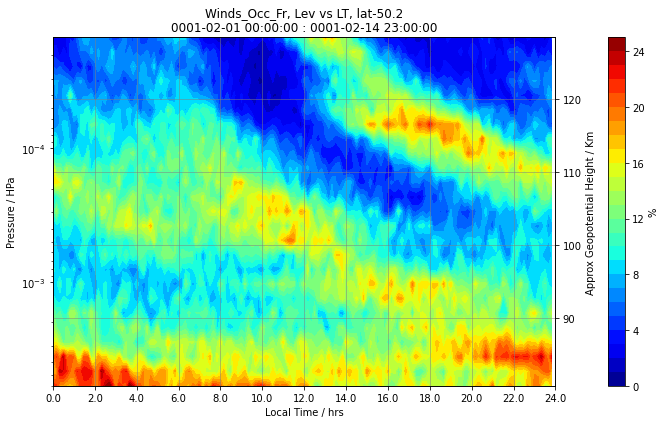

In [180]:

#------------------------ Winds_Occ_Fr -----------------------------

ticks = np.linspace(0, 25, 26)


#fig, ax = plt.subplots(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(10, 6))
C = ax.contourf(timeconv_plot, lev_sl, Winds_Occ_Fr,   #lev_sl[0:-1]
                 levels=ticks,
                 #locator=ticker.LogLocator(),
                 #extend='min',
                 cmap=jet)

ax.set_yscale('log')
ax.set_ylabel('Pressure / HPa')
ax.set_ylim(lev_sl_plot_max, lev_sl_plot_min) 

ax2 = ax.twinx()
ax2.set_ylabel('Approx Geopotential Height / Km')
ax2.set_ylim(Zavg_sl_plot_max,Zavg_sl_plot_min)


ax.set_xlabel('Local Time / hrs')
ax.set_xticks(np.linspace(0,24,13)) 
ax.set_xticklabels(timeconv_plot_ticks[::2]) 

ax.set_title('Winds_Occ_Fr, Lev vs LT, lat' + lat_plot_str + '\n' + times_str_min + ' : ' + times_str_max )

ax.grid(axis='x',color = 'grey', linestyle = '-', linewidth = 0.5)
plt.grid(axis='y',color = 'grey', linestyle = '-', linewidth = 0.5)

#------------------
def fmt(x, pos):
    a, b = '{:.1e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbar = fig.colorbar(C, pad=0.08,ticks=ticks[::4])#,format=ticker.FuncFormatter(fmt))#fraction=0.023, 
#-------------------

cbar.set_label(r'%')

figname='Winds_Occ_Fr: Lev vs LT, lat' + lat_plot_str + ' '+ times_str_min + ' : ' + times_str_max + '.png'
plt.tight_layout()
plt.savefig('./Figures/Jianfei_run/SpE_Identification/Local_Time_Plots/' + 'Winds/'+str(figname)) #

